<a href="https://colab.research.google.com/github/AlonVery/Model-s_for_Diploma/blob/main/OVR_DestTree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scapy
!pip install mocket
!pip install lime
!pip install shap

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from keras.utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.ensemble import IsolationForest
from sklearn.compose import ColumnTransformer
from tensorflow.keras.metrics import Accuracy
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import LearningRateScheduler
from scipy.cluster.hierarchy import dendrogram
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, LabelEncoder
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OrdinalEncoder
import pickle
import joblib
from joblib import dump, load
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from keras.utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.ensemble import IsolationForest
from sklearn.compose import ColumnTransformer
from tensorflow.keras.metrics import Accuracy
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.model_selection import learning_curve, validation_curve
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve, validation_curve
import numpy as np
import pandas as pd
import seaborn as sns
import joblib
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
import lime
import lime.lime_tabular
import shap
from sklearn.model_selection import train_test_split
from plotly.offline import init_notebook_mode, iplot, plot
import plotly as py
import plotly.express as px
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import socket
from scapy.all import sniff
from unittest.mock import patch
import random
import pickle
from joblib import dump, load
from xgboost import XGBClassifier

###Загрузка тренировочного датасета, определение классов атак


In [ ]:
# вытаскиваем тренировачный датасет и разбиваем каждую колонку на нужный нам параметр всего 43
#выделяем каждый датасет отдельно на тест и на треин
#df.head() #df.info() #df['protocol_type'].unique()
#data = df.drop('attack', axis=1)
#df.head()

df = pd.read_csv("https://raw.githubusercontent.com/stepka123/basic-NL-SA/main/KDDTrain%2B.txt")

columns = (['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot'
,'num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root','num_file_creations'
,'num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count','serror_rate'
,'srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count'
,'dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate'
,'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','attack', 'level'])
df.columns = columns
df.head()

df_train=pd.read_csv('https://raw.githubusercontent.com/stepka123/basic-NL-SA/main/KDDTrain%2B.txt',header=None,names=columns)
df_test=pd.read_csv('https://raw.githubusercontent.com/stepka123/basic-NL-SA/stepka123-KDD_Dataset/KDDTrain%2B.txt',header=None,names=columns)
df = pd.concat([df_train, df_test])
df_train.head()
#unique_values = pd.unique(df['service'])
#print(unique_values)
#count_of_ones = df['service'].value_counts()[1]
#print("Количество единиц в столбце 'service':", count_of_ones)
# changing attack labels to their respective attack class
def change_label(df):
    df.attack.replace(['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm'],'Dos',inplace=True)
    df.attack.replace(['ftp_write','guess_passwd','httptunnel','imap','multihop','named','phf','sendmail','snmpgetattack','snmpguess','spy','warezclient','warezmaster','xlock','xsnoop'],'R2L',inplace=True)
    df.attack.replace(['ipsweep','mscan','nmap','portsweep','saint','satan'],'Probe',inplace=True)
    df.attack.replace(['buffer_overflow','loadmodule','perl','ps','rootkit','sqlattack','xterm'],'U2R',inplace=True)
change_label(df)
df.attack.unique()


array(['normal', 'Dos', 'R2L', 'Probe', 'U2R'], dtype=object)

###Использование классификатора Lable Encoder и разметка на тренировочную и тестовые выборки. Так же удаляем дубликаты и нормируем данные.

In [ ]:
le1 = LabelEncoder()
le2 = LabelEncoder()
le3 = LabelEncoder()
le4 = LabelEncoder()

le_protocol_type = le1.fit(df['protocol_type'])
le_service = le2.fit(df['service'])
le_flag = le3.fit(df['flag'])
le_attack = le4.fit(df['attack'])

df['protocol_type'] = le_protocol_type.transform(df['protocol_type'])
df['service'] = le_service.transform(df['service'])
df['flag'] = le_flag.transform(df['flag'])
df['attack'] = le_attack.transform(df['attack'])


y_train= df[['attack']]
X_train= df.drop(labels=['attack'], axis=1)
print('X_train has shape:',X_train.shape,'\ny_train has shape:',y_train.shape)
#чистим будущие данные от NaN/ Null values

def clean_dataset(df_test):
    assert isinstance(df_test, pd.DataFrame), "df_test needs to be a pd.DataFrame"
    df_test.dropna(inplace=True)
    indices_to_keep = ~df_test.isin([np.nan, np.inf, -np.inf]).any(1)
    return data_test[indices_to_keep]

def clean_dataset(df_train):
    assert isinstance(df_train, pd.DataFrame), "df_train needs to be a pd.DataFrame"
    df_train.dropna(inplace=True)
    indices_to_keep = ~df_train.isin([np.nan, np.inf, -np.inf]).any(1)
    return df_train[indices_to_keep]


#Дропаем дубликаты
df_dpl = df.duplicated().sum()
print("Дубликаты: ",df_dpl)
df.drop_duplicates(inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X_train,y_train, test_size=0.20, random_state=42)
target_names = ['normal', 'Dos', 'Probe', 'R2L', 'U2R']

X_train has shape: (125964, 42) 
y_train has shape: (125964, 1)
Дубликаты:  0


###Обучение модели и вывод оценки точности определения правильности ответа

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Определение признаков (X) и целевой переменной (y)
X = df.drop('attack', axis=1)  # Признаки, кроме целевой переменной
y = df['attack']  # Целевая переменная

# Преобразование имен столбцов в строковый формат
X.columns = X.columns.astype(str)

# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=48)

# Создание и обучение модели One-vs-Rest с DecisionTreeClassifier
ovr_classifier = OneVsRestClassifier(DecisionTreeClassifier())
ovr_classifier.fit(X_train, y_train)

# Оценка качества модели на тестовом наборе данных
predictions = ovr_classifier.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.9985710316357719


###Испытание на другом тестовом датасете

In [ ]:
filename = 'ovr_classifier.sav'
pickle.dump(ovr_classifier, open(filename, 'wb'))

In [ ]:
df_test = pd.read_csv('https://raw.githubusercontent.com/stepka123/basic-NL-SA/stepka123-KDD_Dataset/KDDTrain%2B_20Percent.txt')

columns = (['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot'
,'num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root','num_file_creations'
,'num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count','serror_rate'
,'srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count'
,'dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate'
,'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','attack','level'])

df_test.columns = columns
# changing attack labels to their respective attack class
def change_label(df_test):
    df_test.attack.replace(['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm'],'Dos',inplace=True)
    df_test.attack.replace(['ftp_write','guess_passwd','httptunnel','imap','multihop','named','phf','sendmail','snmpgetattack','snmpguess','spy','warezclient','warezmaster','xlock','xsnoop'],'R2L',inplace=True)
    df_test.attack.replace(['ipsweep','mscan','nmap','portsweep','saint','satan'],'Probe',inplace=True)
    df_test.attack.replace(['buffer_overflow','loadmodule','perl','ps','rootkit','sqlattack','xterm'],'U2R',inplace=True)
change_label(df_test)
df_test.attack.unique()


array(['normal', 'Dos', 'R2L', 'Probe', 'U2R'], dtype=object)

In [ ]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from scapy.all import *
import random
import pandas as pd
from sklearn import preprocessing
import numpy as np
# Создание объектов LabelEncoder для каждого категориального столбца
le_protocol_type = LabelEncoder()
le_service = LabelEncoder()
le_flag = LabelEncoder()

# Преобразование категориальных признаков в числовые значения
df_test['protocol_type'] = le_protocol_type.fit_transform(df_test['protocol_type'])
df_test['service'] = le_service.fit_transform(df_test['service'])
df_test['flag'] = le_flag.fit_transform(df_test['flag'])

# Преобразование категориальных признаков в one-hot encoding
encoder = OneHotEncoder()
X_encoded = encoder.fit_transform(df_test[['protocol_type', 'service', 'flag']])

# Преобразование разреженной матрицы в массив NumPy
X_encoded_array = X_encoded.toarray()
# Check the type of le_protocol_type
print(type(le_protocol_type))

# Check if the transform method is available in the le_protocol_type object
print(hasattr(le_protocol_type, 'transform'))

# Try to access the transform method directly
print(le_protocol_type.transform)

<class 'sklearn.preprocessing._label.LabelEncoder'>
True
<bound method LabelEncoder.transform of LabelEncoder()>


In [ ]:
loaded_model = pickle.load(open(filename, 'rb'))

In [ ]:
def intrusion_check(packet):
    packet[1] = le_protocol_type.transform([packet[1]])[0]
    packet[2] = le_service.transform([packet[2]])[0]
    packet[3] = le_flag.transform([packet[3]])[0]
    pred = loaded_model.predict(np.reshape(packet, (1, 42)))
    predicted = le_attack.inverse_transform(pred)

    return predicted[0]

In [ ]:
def capture_packet(count=float('inf')):
    filtered_packets = []

    def handle_sniffed_packet(packet):
        num = random.randint(0, 11849)
        check = intrusion_check(list(df_test.iloc[num]))
        if check == 'normal':
            filtered_packets.append(packet)
            print(f'Packet Safe, From [{packet.src}] To [{packet.dst}]')
        else:
            print(f'Caution! Found {check}, From [{packet.src}] To [{packet.dst}]')

    # Start capturing packets using sniff
    sniff(prn=handle_sniffed_packet, count=count)

    return filtered_packets

In [ ]:
# Capture 20 packets and receive the safe packets
packets = capture_packet()

Packet Safe, From [02:42:11:88:8d:11] To [02:42:ac:1c:00:0c]
Packet Safe, From [02:42:ac:1c:00:0c] To [02:42:11:88:8d:11]
Packet Safe, From [02:42:11:88:8d:11] To [02:42:ac:1c:00:0c]
Caution! Found Dos, From [02:42:ac:1c:00:0c] To [02:42:11:88:8d:11]
Packet Safe, From [02:42:ac:1c:00:0c] To [02:42:11:88:8d:11]
Packet Safe, From [02:42:11:88:8d:11] To [02:42:ac:1c:00:0c]
Caution! Found Dos, From [02:42:ac:1c:00:0c] To [02:42:11:88:8d:11]
Packet Safe, From [02:42:11:88:8d:11] To [02:42:ac:1c:00:0c]
Caution! Found R2L, From [02:42:11:88:8d:11] To [02:42:ac:1c:00:0c]
Caution! Found Dos, From [02:42:ac:1c:00:0c] To [02:42:11:88:8d:11]
Packet Safe, From [02:42:11:88:8d:11] To [02:42:ac:1c:00:0c]
Caution! Found Dos, From [02:42:11:88:8d:11] To [02:42:ac:1c:00:0c]
Caution! Found Dos, From [02:42:ac:1c:00:0c] To [02:42:11:88:8d:11]
Caution! Found Probe, From [02:42:11:88:8d:11] To [02:42:ac:1c:00:0c]
Packet Safe, From [02:42:11:88:8d:11] To [02:42:ac:1c:00:0c]
Caution! Found Dos, From [02:42:11

###Оценка работы модели. Проверка на переобучение и оценка необходимых метрик

Accuracy: 0.9985710316357719
Recall: 0.9985710316357719
F1 Score: 0.9985906423282508


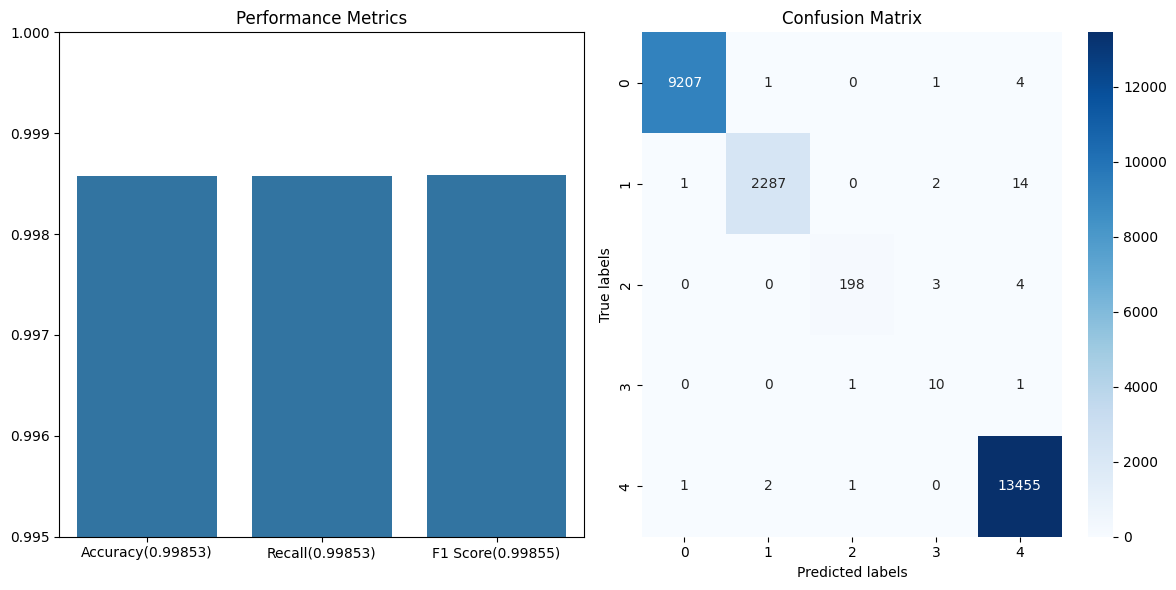

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Вычисление точности
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

# Вычисление полноты
recall = recall_score(y_test, predictions, average='weighted')
print("Recall:", recall)

# Вычисление F1-меры
f1 = f1_score(y_test, predictions, average='weighted')
print("F1 Score:", f1)

# Построение матрицы ошибок
cm = confusion_matrix(y_test, predictions)

# Построение графика для точности, полноты и F1-меры
plt.figure(figsize=(12, 6))

# Точность, полнота и F1-мера
plt.subplot(1, 2, 1)
metrics = ['Accuracy(0.99853)', 'Recall(0.99853)', 'F1 Score(0.99855)']
values = [accuracy, recall, f1]
sns.barplot(x=metrics, y=values)
plt.title('Performance Metrics')
plt.ylim(0.995000, 1.000000)  # Измененный диапазон отображения
# Матрица ошибок
plt.subplot(1, 2, 2)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

plt.tight_layout()
plt.show()


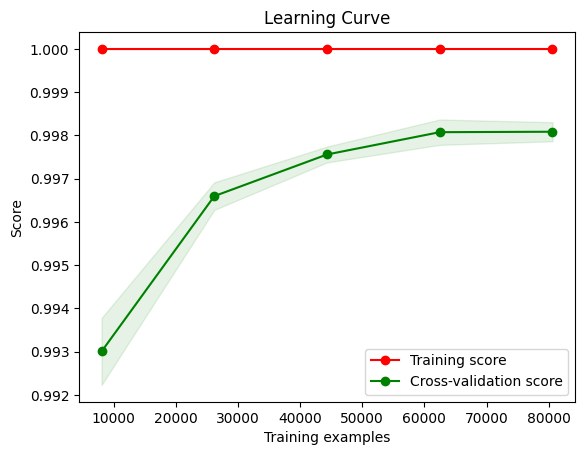

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve, validation_curve

def plot_learning_curve(estimator, X, y, cv=None, train_sizes=np.linspace(.1, 1.0, 5)):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure()
    plt.title("Learning Curve")
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Пример использования
plot_learning_curve(ovr_classifier, X_train, y_train, cv=5)
plt.show()
